In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
import random
from kymatio.numpy import Scattering2D
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The dataset was processed using torchvision transforms}, as 
#\texttt{ransform }$= t\texttt{ransforms.}C\texttt{ompose(}[ transforms.Resize((40, 40))  transforms.ToTensor()
])
$

In [7]:
Xtrain=np.load("datasets/Xtrain.npy")
ytrain=np.load("datasets/ytrain.npy")
Xtest=np.load("datasets/Xtest.npy")
ytest=np.load("datasets/ytest.npy")


In [9]:
#Preprocessing using the scattering transform 
H=Xtrain.shape[-2]
W=Xtrain.shape[-1]
scattering = Scattering2D(shape=(H, W), J=4, L=6)

In [10]:
Xtrain=scattering(Xtrain)
Xtest=scattering(Xtest)

In [12]:
#Preprocessing
Xtrain=Xtrain.reshape(len(ytrain),-1)
Xtest=Xtest.reshape(len(ytest),-1)
mean=Xtrain.mean(axis=0)
norm=Xtrain.std()
Xtrain=Xtrain -mean 
Xtrain/=norm
Xtest=Xtest - mean
Xtest/=norm
#Going from 0,1 labels to -1,1
ytrain=np.sign(ytrain-.5)
ytest=np.sign(ytest-.5)

In [13]:
#Shuffling the training set
perm = list(range(len(ytrain)))
random.shuffle(perm)
Xtrain=Xtrain[perm]
ytrain=ytrain[perm]

In [19]:
def balance(X, y): #For a given dataset X and labels y, resamples so that classes are balanced.
    
    classes = [-1,1]
    idx_per_class = {c: np.where(y == c)[0] for c in classes}

    N = len(y)
    num_classes = 2
    per_class= {1: int(N/2), -1: N- int(N/2)}

    sampled_indices = []

    for c in classes:
        idx = idx_per_class[c]
        if len(idx) >= per_class[c]:   #if majority class, downsampled without replacement.
            chosen = np.random.choice(idx, per_class[c], replace=False)
        else:                          #if minority class, upsampled with replacement.
            chosen = np.random.choice(idx, per_class[c], replace=True)

        sampled_indices.append(chosen)

    sampled_indices = np.concatenate(sampled_indices)
    

    return X[sampled_indices], y[sampled_indices]

In [23]:
γ=.5           #budget
λ=.01          #regularization

In [25]:
N=len(ytrain)

In [35]:
def get_error(ψ, C=1/λ):

    n0=int(ψ*N)
    ng=int(γ*N)
    
    idx=np.random.choice(range(len(ytrain)),n0)
    idx_=np.array([k for k in range(N) if k not in idx])
    X0=Xtrain[idx]
    y0=ytrain[idx]

    X0, y0=balance(X0,y0)                          #balancing the dataset
    lr=LR(C=C, fit_intercept=False)                #Fitting logistic regression 
    lr.fit(X0, y0, sample_weight=np.ones(n0)/n0)
    
    Xr=Xtrain[idx_]                                #remaining unlabeled data
    yr=ytrain[idx_]                                #remaining labels (assumed unknown)
    
    w0=(lr.coef_).flatten()    
    u=np.abs(Xr@w0)                                #predictions of the base classifier

    m=ng-n0                                        #remaining budget
    u_sorted = sorted(u)
    lower = u_sorted[m-1]                          
    upper = u_sorted[m]
    κ = (lower + upper) / 2                        #There are m samples with u[i]<\kappa
    

    X=np.vstack((X0, Xr[u<κ]))                     #Concatenating X0 with the selected samples
    y=np.hstack((y0, yr[u<κ]))
    X, y=balance(X,y)                              #Balancing before training
    lr=LR(C=C, fit_intercept=False)                #Fitting logistic regression
    nf=X.shape[0]
    lr.fit(X, y, sample_weight=np.ones(nf)/nf)
    ypred=lr.predict(Xtest)                       #Error is evaluated on unbalanced test set.
    error=np.mean(ypred!=ytest)

    return error

    

    
    


In [61]:
psis=np.linspace(.005, .995*γ, 10)
errors=[]
first=True
for ψ in tqdm.tqdm(psis):
    running=[]
    for i in range(50):
        err=get_error(ψ)
        running.append(err)
    rrunning=np.array(running)
    if first:
        first=False
        errors=running
    else:
        errors=np.vstack((errors, running))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.67s/it]


Text(0, 0.5, '$\\mathcal{E}_{\\rm gen}$')

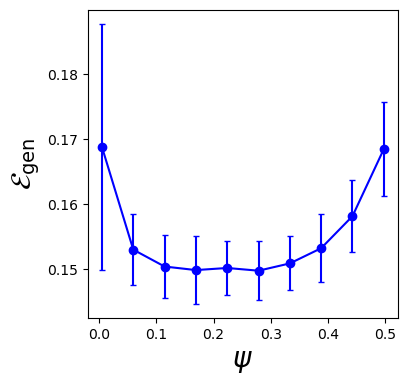

In [85]:
plt.figure(figsize=(4,4))
plt.errorbar(psis,errors.mean(1),errors.std(1), marker="o", capsize=2, c="b")
plt.xlabel(r"$\psi$", fontsize=20)
plt.ylabel(r"$\mathcal{E}_{\rm gen}$", fontsize=20)